In [1]:
import ee
import rasterio
import numpy as np
from pprint import pprint
from IPython.display import display
from IPython.display import Image
import matplotlib.pyplot as plt
from matplotlib import colors

In [2]:
ee.Initialize()

In [6]:
from channel_classifier.internal.ee_utils import add_labels, compute_error_image, download_tiff, get_landsat_images, get_landsat_composite

In [25]:
path, row = [3, 69] # RMDD
#path, row = [232, 71] # Mamore
start_date = '1984-01-01'
end_date = '2018-01-01'

In [27]:
datasets = ['LANDSAT/LC08/C01/T1_TOA', 'LANDSAT/LT05/C01/T1_TOA', 'LANDSAT/LE07/C01/T1_TOA']
images = ee.ImageCollection([])
for ds in datasets:
    this_images = get_landsat_images(path, row, start_date, end_date, dataset_path=ds, cloud_thresh=10)
    images = images.merge(this_images)

In [28]:
print(images.size().getInfo())

49


In [29]:
def plot_image(images):
    filename = download_tiff(image.clip(image.geometry()), scale=240)
    with rasterio.open(filename) as r:
        im = r.read()
        rgb = np.stack([im[3], im[2], im[1]], axis=-1)
        fig, ax = plt.subplots(1, 1, figsize=(12,12))
        im = ax.imshow(rgb)

In [30]:
image = ee.Image(images.first())

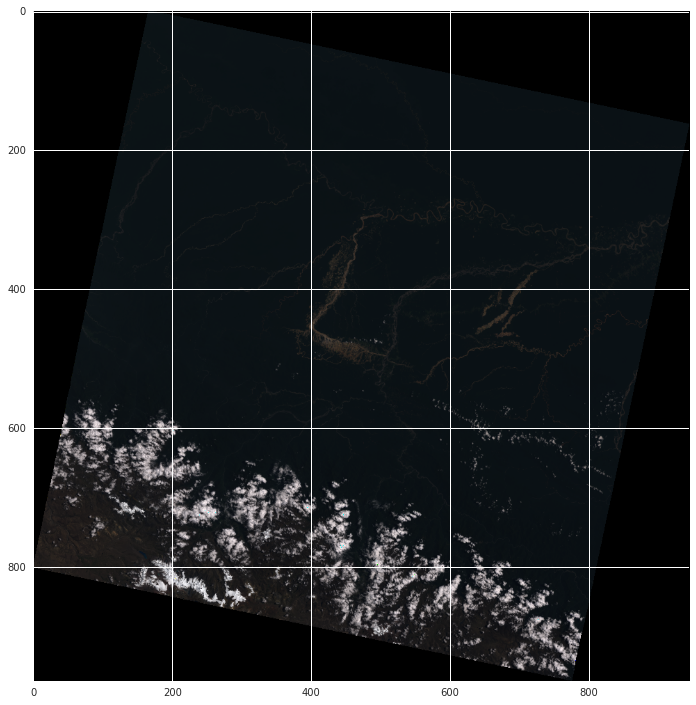

In [31]:
plot_image(image)